In [1]:
#importing required libraries and setting matplotlib to inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [2]:
#grabbing the dataset
df = pd.read_csv('kc_house_data.csv')

In [3]:
#dropping id and date columns
df.drop(['id', 'date'], axis=1, inplace=True)

In [4]:
#replacing missing data in sqft_basement with column mean
sqft_basement_numerical = df.sqft_basement[df.sqft_basement != '?']
sqft_basement_numerical = sqft_basement_numerical.astype(float)
sqft_basement_numerical_mean = round(sqft_basement_numerical.mean(),1)
df['sqft_basement'] = (df['sqft_basement'].map(lambda x: sqft_basement_numerical_mean if x == '?' else x)).astype(float)

In [5]:
#replacing null values in view with 0
df['view'] = df['view'].fillna(0)

In [6]:
#replacing null values in waterfront with 0
df['waterfront'] = df['waterfront'].fillna(0)

In [7]:
#replacing yr_renovated with categorical column renovated
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df['renovated'] = df.apply(lambda row: 0 if row.yr_renovated < 1 else 1, axis=1)
df.drop('yr_renovated', axis=1, inplace=True)

In [8]:
#dropping lat, long, and zipcode columns
df.drop('lat', axis=1, inplace=True)
df.drop('long', axis=1, inplace=True)
df.drop('zipcode', axis=1, inplace=True)

In [9]:
#stepwise selection function
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [10]:
#initial linear regression with all variables
X = df.drop('price', axis=1)
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=47)
linreg = LinearRegression()
linreg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
#checking MSE of initial regression
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 46093680105.63467
Test Mean Squarred Error: 48440819014.62178


In [12]:
#for i in df.columns:
 #   df[i] = (df[i] - df[i].mean()) / df[i].std()
#df.head()

In [13]:
#checking p-value of predictors
result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

Add  waterfront                     with p-value 0.0
Add  grade                          with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  view                           with p-value 1.45107e-104
Add  bedrooms                       with p-value 2.58954e-51
Add  bathrooms                      with p-value 6.49456e-65
Add  sqft_lot15                     with p-value 3.3687e-24
Add  condition                      with p-value 5.15706e-13
Add  floors                         with p-value 2.93718e-09
Add  sqft_living15                  with p-value 9.83367e-12
Add  sqft_living                    with p-value 9.09171e-06
Add  renovated                      with p-value 0.00124564
resulting features:
['waterfront', 'grade', 'yr_built', 'sqft_above', 'sqft_basement', 'view', 'bedrooms', 'bathrooms', 'sqft_lot15', 'condition', 'floors', 'sqft_living15', 'sqft_living'

In [78]:
#checking r-squared and adjusted r-squared for predictors chosen by RFE
i = 1
while i <= (int(len(df.drop('price', axis=1).columns))):
    linreg = LinearRegression()
    selector = RFE(linreg, n_features_to_select = i)
    selector = selector.fit(X_train, y_train) 
    selected_columns = X.columns[selector.support_ ]

    model = sm.OLS(y_train,X_train[selected_columns])
    results = model.fit()
    results.summary()
    print(str(i) + " predictors -")
    print("R-squared = " + str(results.rsquared))
    print("Adjusted R-squared = " + str(results.rsquared_adj))
    print(str((X_train.columns[selector.support_])))
    print("--------------------------------------------")
    i += 1

1 predictors -
R-squared = 0.005945692787605816
Adjusted R-squared = 0.005888879944992098
Index(['waterfront'], dtype='object')
--------------------------------------------
2 predictors -
R-squared = 0.9861971102936212
Adjusted R-squared = 0.9861955324598642
Index(['waterfront', 'grade'], dtype='object')
--------------------------------------------
3 predictors -
R-squared = 0.9862903201667741
Adjusted R-squared = 0.9862879692642591
Index(['waterfront', 'view', 'grade'], dtype='object')
--------------------------------------------
4 predictors -
R-squared = 0.9866184944862949
Adjusted R-squared = 0.9866154348074304
Index(['waterfront', 'view', 'grade', 'basement'], dtype='object')
--------------------------------------------
5 predictors -
R-squared = 0.9887856698516452
Adjusted R-squared = 0.9887824644751665
Index(['bathrooms', 'waterfront', 'view', 'grade', 'basement'], dtype='object')
--------------------------------------------
6 predictors -
R-squared = 0.9889628979724613
Adjusted

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000169E2F700B8>,
      dtype=object)

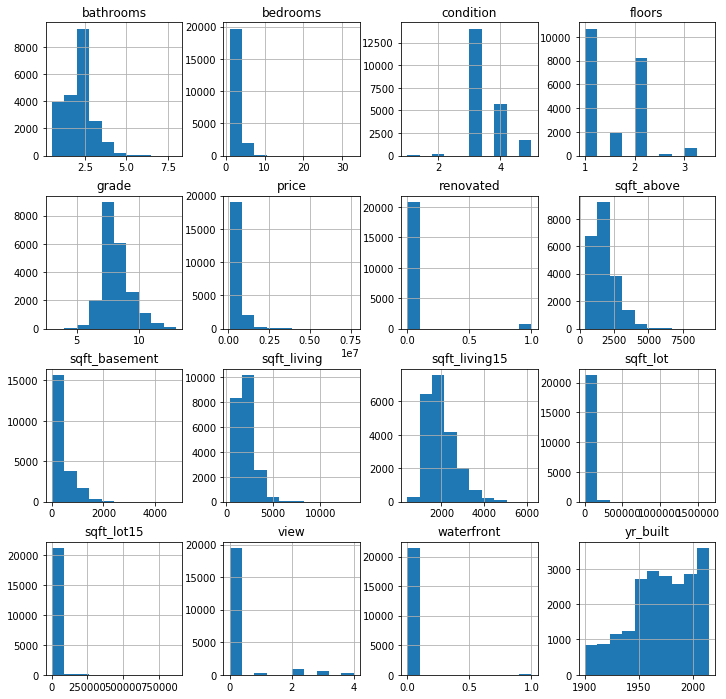

In [16]:
#intial histogram of all variables to examine skew and distribution
df.hist(figsize=(12,12))

In [17]:
#checking bedrooms for outliers
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

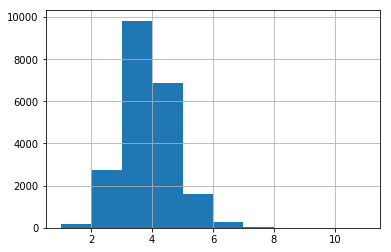

In [20]:
#histogram before removal of outliers
df.bedrooms.hist()

In [21]:
#removing outliers
df.drop(df.index[df['bedrooms'] >= 8], inplace=True)

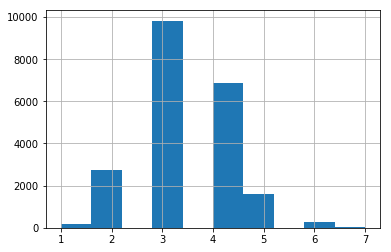

In [22]:
#histogram after removal of outliers
df.bedrooms.hist()

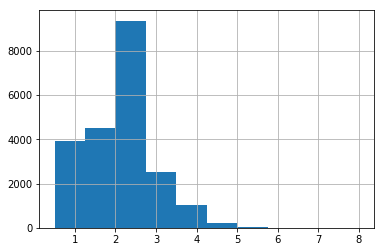

In [23]:
#bathrooms histogram
df.bathrooms.hist()

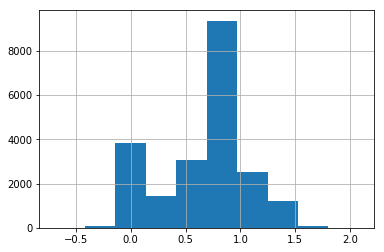

In [24]:
#using log transformation on bathrooms
(np.log(df.bathrooms)).hist()

In [25]:
#transforming bathrooms
df.bathrooms = np.log(df.bathrooms)

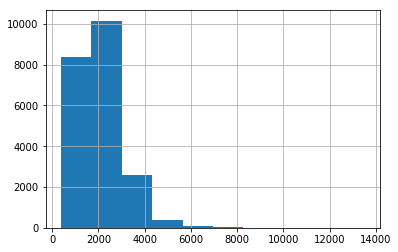

In [28]:
#sqft_living histogram
df.sqft_living.hist()

In [29]:
#checking count of outliers
print(len(df[df.sqft_living > 8000]))
print(len(df[df.sqft_living > 6000]))
print(len(df[df.sqft_living > 4000]))

9
67
773


In [30]:
#removing outliers
df.drop(df.index[df['sqft_living'] > 4000], inplace=True)

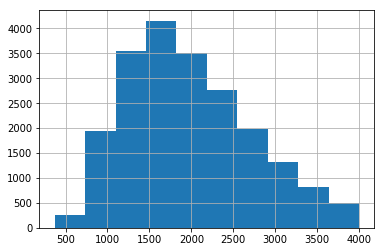

In [31]:
#histogram after removal of outliers
df.sqft_living.hist()

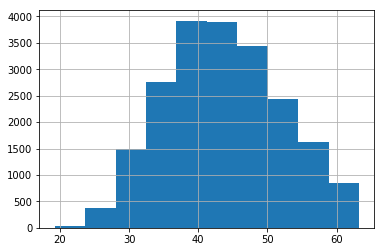

In [32]:
#histogram of square root transformed sqft_living
(np.sqrt(df.sqft_living)).hist()

In [33]:
#square root transformation on sqft_living
df.sqft_living = np.sqrt(df.sqft_living)

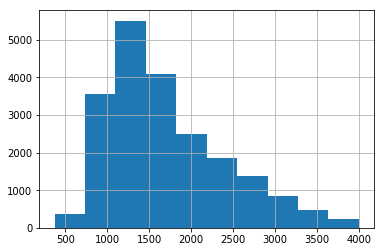

In [34]:
#sqft_above histogram
df.sqft_above.hist()

In [35]:
#square root transformation
df.sqft_above = np.sqrt(df.sqft_above)

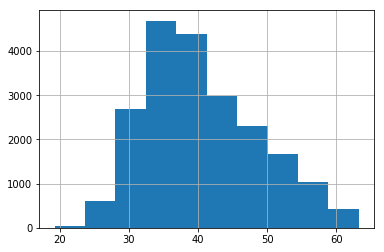

In [36]:
#square root transformed histogram
df.sqft_above.hist()

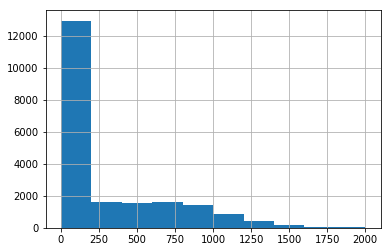

In [37]:
#sqft_basement histogram
df.sqft_basement.hist()

In [38]:
#creating new column that declares whether or not a home has a basement
df['basement'] = df.apply(lambda row: 0 if row.sqft_basement == 0 else 1, axis=1)

In [39]:
#removing old sqft_basement column
df.drop('sqft_basement', axis=1, inplace=True)

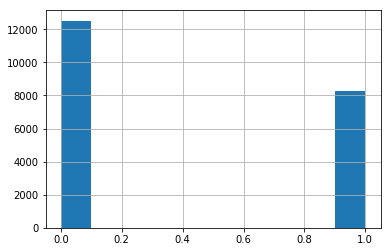

In [40]:
#new binary basement histogram
df.basement.hist()

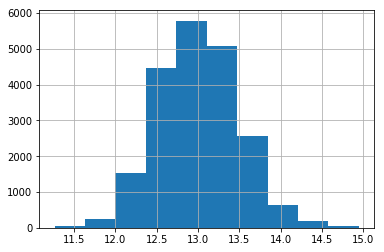

In [80]:
#price histogram
df.price.hist()

In [41]:
#log transformation on price
df.price = np.log(df.price)
df.price.hist()

In [42]:
#viewing stats of yr_built
df.yr_built.describe()

count    20800.000000
mean      1970.352644
std         29.308936
min       1900.000000
25%       1951.000000
50%       1973.000000
75%       1995.000000
max       2015.000000
Name: yr_built, dtype: float64

In [43]:
#creating new column age that declares the age of the home
df['age'] = (df.yr_built.max() - df.yr_built)

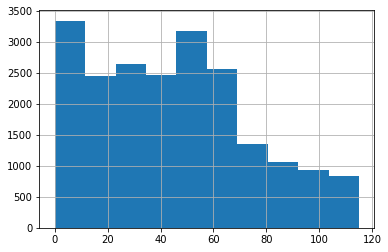

In [44]:
#histogram of new age column
df.age.hist()

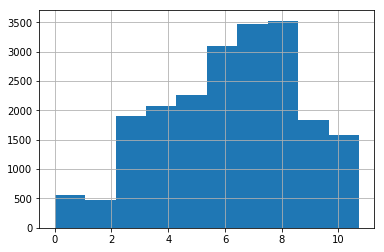

In [45]:
#square root transformation on age
df.age = np.sqrt(df.age)
(np.sqrt(df.age)).hist()

In [47]:
#removal of old yr_built column
df.drop('yr_built',axis=1,inplace=True)

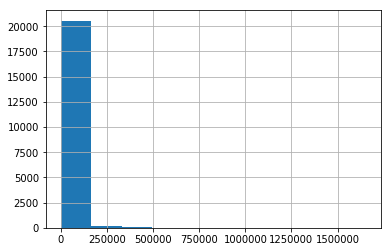

In [48]:
#sqft_lot histogram
df.sqft_lot.hist()

In [49]:
#checking number of outliers
len(df[df.sqft_lot>200000])

213

In [50]:
#removal of outliers
df.drop(df.index[df['sqft_lot'] > 200000], inplace=True)

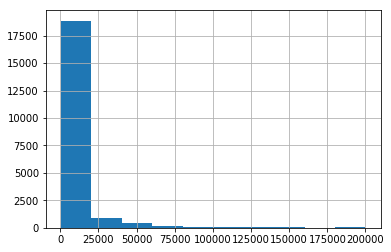

In [51]:
#histogram after removal of outliers
df.sqft_lot.hist()

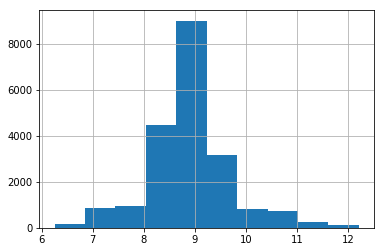

In [52]:
#log transformation of sqft_lot
df.sqft_lot = np.log(df.sqft_lot)
sqft_lot.hist()

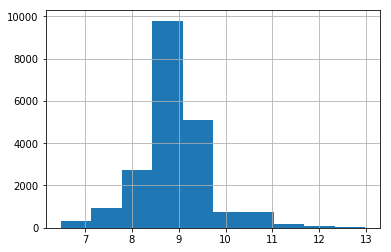

In [81]:
#histogram of sqft_lot15
df.sqft_lot15.hist()

In [54]:
#log transformed sqft_lot15
df.sqft_lot15 = np.log(df.sqft_lot15)
df.sqft_lot15.hist()

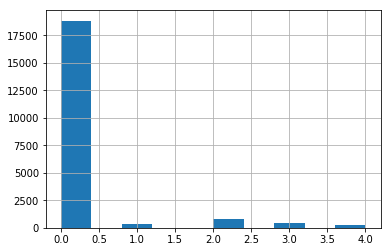

In [55]:
#view histogram
df.view.hist()

In [56]:
#unique values of view
df.view.unique()

array([0., 3., 4., 2., 1.])

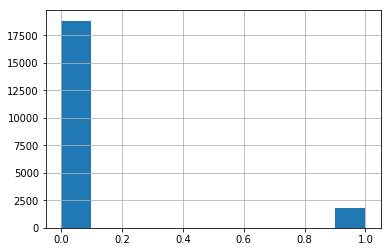

In [82]:
#converting all view values above 0 to 1 to signify that the home has been viewed
i = 4
while i > 0:
    df.view = df.view.replace(i, 1)
    i -= 1
df.view.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000169E7B98668>,
      dtype=object)

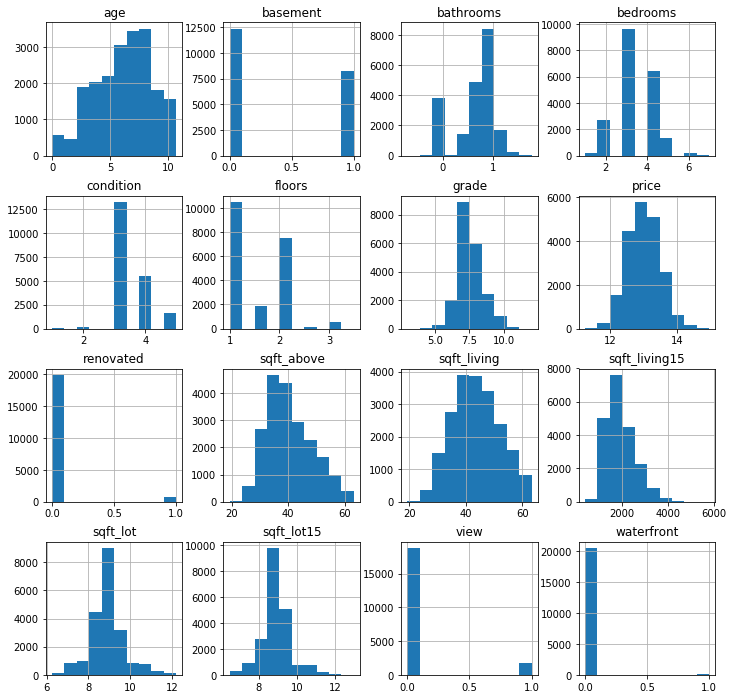

In [83]:
#updated histogram of all variables after transformations and adjustments
df.hist(figsize=(12,12))

In [59]:
#RFE regression of all predictors
X = df.drop('price', axis=1)
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state=47)
i = 1
while i <= (int(len(df.drop('price', axis=1).columns))):
    linreg = LinearRegression()
    selector = RFE(linreg, n_features_to_select = i)
    selector = selector.fit(X_train, y_train) 
    selected_columns = X.columns[selector.support_ ]

    model = sm.OLS(y_train,X_train[selected_columns])
    results = model.fit()
    results.summary()
    print(str(i) + " predictors - " + str(results.rsquared))
    print("------- " + str(X_train.columns[selector.support_]))
    i += 1

1 predictors - 0.09120754284332022
------- Index(['view'], dtype='object')
2 predictors - 0.09121216011384703
------- Index(['waterfront', 'view'], dtype='object')
3 predictors - 0.9863557986824313
------- Index(['waterfront', 'view', 'grade'], dtype='object')
4 predictors - 0.9866786169680228
------- Index(['waterfront', 'view', 'grade', 'basement'], dtype='object')
5 predictors - 0.9888767380548678
------- Index(['bathrooms', 'waterfront', 'view', 'grade', 'basement'], dtype='object')
6 predictors - 0.9890447323863452
------- Index(['bathrooms', 'floors', 'waterfront', 'view', 'grade', 'basement'], dtype='object')
7 predictors - 0.9940252366431639
------- Index(['bathrooms', 'floors', 'waterfront', 'view', 'grade', 'basement',
       'age'],
      dtype='object')
8 predictors - 0.9941157533758272
------- Index(['bathrooms', 'floors', 'waterfront', 'view', 'grade', 'renovated',
       'basement', 'age'],
      dtype='object')
9 predictors - 0.9950831518803513
------- Index(['bathrooms

In [60]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_living15', 'sqft_lot15', 'renovated', 'basement', 'age'],
      dtype='object')

In [61]:
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 15)
selector = selector.fit(X_train, y_train) 
selected_columns = X.columns[selector.support_]
linreg.fit(X_train[selected_columns],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [62]:
i=0
while i < len(selected_columns):
    print(str(selected_columns[i]) + " " + str(linreg.coef_[i]))
    i += 1

bedrooms -0.035778254370156345
bathrooms 0.05802882936448764
sqft_living 0.014049996711280745
sqft_lot -0.037789494563219006
floors 0.08280268704254984
waterfront 0.44583833335240225
view 0.11191563628483948
condition 0.05256572592468691
grade 0.1931793552055317
sqft_above 0.002920112825766573
sqft_living15 0.0001503552426653765
sqft_lot15 -0.06292806665825461
renovated 0.07021195533517915
basement 0.08469829902841622
age 0.06275638492889321


In [63]:
from sklearn.metrics import mean_squared_error
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.09282541098882754
Test Mean Squarred Error: 0.09485821776112013


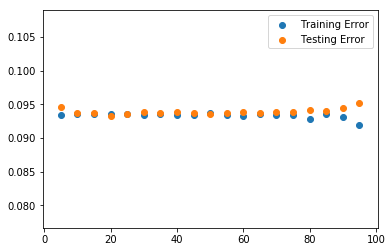

In [64]:
X = df.drop('price', axis=1)
y = df.price
train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

In [65]:
linreg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=47)
selector = RFE(linreg, n_features_to_select = 15)
selector = selector.fit(X_train, y_train) 
selected_columns = X_train.columns[selector.support_ ]
linreg.fit(X_train[selected_columns],y_train)
print(linreg.coef_)
print(linreg.score(X_test, y_test))

[-3.55761008e-02  6.31257090e-02  1.40002684e-02 -3.93120316e-02
  7.59804789e-02  4.39750206e-01  1.11005701e-01  5.06432247e-02
  1.94762338e-01  2.95676909e-03  1.46930907e-04 -6.22464816e-02
  6.50817359e-02  8.24975446e-02  6.20030022e-02]
0.6160080451110045


In [66]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=47)
forest_reg.fit(X_train, y_train)
print('Random Forest R squared": %.4f' % forest_reg.score(X_test, y_test))

C:\Users\sparr\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Random Forest R squared": 0.6466


In [67]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)
print('Gradient Boosting R squared": %.4f' % model.score(X_test, y_test))

Gradient Boosting R squared": 0.6696


In [68]:
feature_labels = np.array(df.columns)
importance = model.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

sqft_lot15-0.29%
waterfront-1.42%
renovated-1.77%
price-1.80%
sqft_lot-3.03%
floors-3.14%
bedrooms-3.40%
sqft_living-3.66%
view-5.69%
grade-6.05%
sqft_living15-10.37%
bathrooms-11.86%
sqft_above-13.79%
condition-14.30%
basement-19.45%


In [69]:
import statsmodels.api as sm
model = sm.OLS(y_train,X_train)
results = model.fit()

In [70]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 4.526e+05
Date:                Thu, 25 Oct 2018   Prob (F-statistic):               0.00
Time:                        16:05:25   Log-Likelihood:                -17547.
No. Observations:               17498   AIC:                         3.512e+04
Df Residuals:                   17483   BIC:                         3.524e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms          0.0447      0.008      5.887      0.000       0.030       0.060
bathrooms        -0.1884      0.023     -8.255      0.000      -0.233      -0.144
sqft_living      -0.0013      0.002     -0.551      0.582      -0.006       0.003
sqft_lot          0.1376      0.016      8.660      0.000       0.106       0.169
floors            0.8656      0.013     65.422      0.000       0.840       0.891
waterfront       -0.1615      0.071     -2.265      0.024      -0.301      -0.022
view             -0.0705      0.019     -3.624      0.000      -0.109      -0.032
condition         0.2694      0.008     32.394      0.000       0.253       0.286
grade             0.5915      0.007     83.578      0.000       0.578       0.605
sqft_above       -0.0017      0.002     -0.711      0.477      -0.006       0.003
sqft_living15    -0.0003   1.29e-05    -22.276      0.000      -0.000      -0.000
sqft_lot15        0.5289      0.016     32.992      0.000       0.497       0.560
renovated        -0.0788      0.029     -2.713      0.007      -0.136      -0.022
basement          0.3804      0.020     19.451      0.000       0.342       0.419
age               0.1407      0.003     46.189      0.000       0.135       0.147
==============================================================================
Omnibus:                      752.188   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1002.297
Skew:                          -0.439   Prob(JB):                    2.26e-218
Kurtosis:                       3.776   Cond. No.                     2.90e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
from sklearn.metrics import mean_squared_error

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.09376613179040377
Test Mean Squarred Error: 0.09220420146036985


In [72]:
cv_10_results = cross_val_score(linreg, X_test, y_test, cv=50, scoring="neg_mean_squared_error")

cv_10_results

array([-0.07428801, -0.08735429, -0.10779664, -0.10852647, -0.07027502,
       -0.08399183, -0.0816896 , -0.10095874, -0.11021037, -0.10186611,
       -0.05802304, -0.10213215, -0.09331837, -0.07962663, -0.06342976,
       -0.09269057, -0.06835253, -0.09593314, -0.11987583, -0.09552275,
       -0.11854481, -0.08862161, -0.10601888, -0.08970363, -0.10431378,
       -0.0929516 , -0.10766104, -0.08264981, -0.10222526, -0.08887743,
       -0.08310837, -0.09997257, -0.09496709, -0.08807196, -0.09559865,
       -0.09353882, -0.08735243, -0.12146524, -0.09827966, -0.08521247,
       -0.0826627 , -0.08110022, -0.09706718, -0.08765526, -0.08663787,
       -0.05797134, -0.08719211, -0.10563456, -0.09601554, -0.12921187])